<a href="https://colab.research.google.com/github/alvesnicole/RareSpeciesDataset/blob/main/classificacao_familias_raras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importações**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import cv2
from PIL import Image
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# **Carregamento do dataset**

In [ ]:
dataset = load_dataset("imageomics/rare-species")
train_data = dataset['train']
print(f"Dataset carregado: {len(train_data)} exemplos")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00009.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

data/train-00001-of-00009.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

data/train-00002-of-00009.parquet:   0%|          | 0.00/521M [00:00<?, ?B/s]

data/train-00003-of-00009.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

data/train-00004-of-00009.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00005-of-00009.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

data/train-00006-of-00009.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

data/train-00007-of-00009.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

data/train-00008-of-00009.parquet:   0%|          | 0.00/483M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11983 [00:00<?, ? examples/s]

Dataset carregado: 11983 exemplos


#**EDA - Análise Exploratória de dados**

In [ ]:
def basic_eda(train_data):
    print("ANÁLISE EXPLORATÓRIA:")
    print(f"Total de exemplos: {len(train_data)}")

    species_counts = Counter(train_data['species'])
    family_counts = Counter(train_data['family'])

    print(f"Espécies únicas: {len(species_counts)}")
    print(f"Famílias únicas: {len(family_counts)}")
    print(f"Espécies com 1 exemplo: {sum(1 for count in species_counts.values() if count == 1)}")

    print("\nTop 5 famílias:")
    for family, count in family_counts.most_common(5):
        print(f"  {family}: {count}")

basic_eda(train_data)

ANÁLISE EXPLORATÓRIA:
Total de exemplos: 11983
Espécies únicas: 385
Famílias únicas: 202
Espécies com 1 exemplo: 0

Top 5 famílias:
  Dactyloidae: 300
  Cercopithecidae: 300
  Formicidae: 291
  Carcharhinidae: 270
  Salamandridae: 270


# Visualização

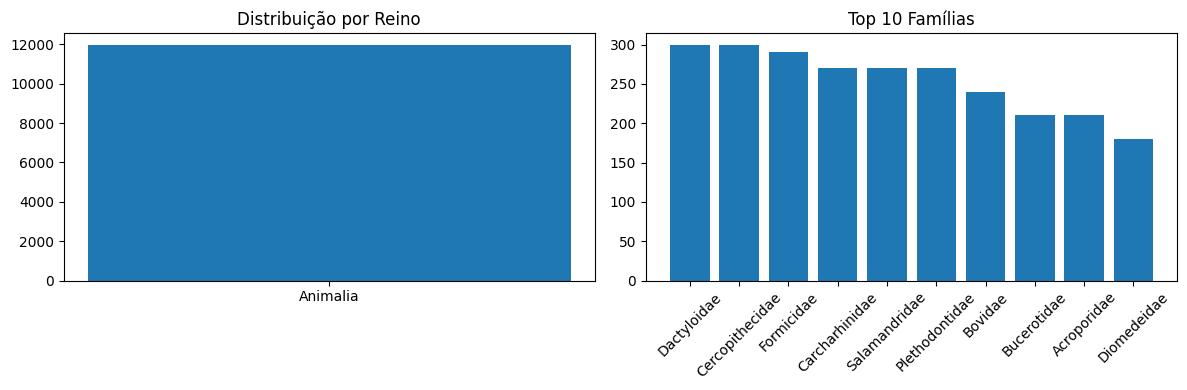

In [ ]:
def plot_distributions(train_data):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    kingdoms = Counter(train_data['kingdom'])
    axes[0].bar(kingdoms.keys(), kingdoms.values())
    axes[0].set_title('Distribuição por Reino')

    families = Counter(train_data['family']).most_common(10)
    family_names = [fam[0] for fam in families]
    family_values = [fam[1] for fam in families]
    axes[1].bar(family_names, family_values)
    axes[1].set_title('Top 10 Famílias')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

plot_distributions(train_data)

# PRÉ-PROCESSAMENTO

In [ ]:
def prepare_data(train_data, target_level='family', val_ratio=0.2):
    data_list = []
    for i in range(len(train_data)):
        item = train_data[i]
        data_list.append({
            'original_index': i,
            'family': item['family'],
            'species': item['species'],
            'target': item[target_level]
        })

    train_list, val_list = train_test_split(
        data_list,
        test_size=val_ratio,
        random_state=42,
        stratify=[item['target'] for item in data_list]
    )

    return train_list, val_list

train_list, val_list = prepare_data(train_data)
print(f"Dados preparados: {len(train_list)} treino, {len(val_list)} validação")

Dados preparados: 9586 treino, 2397 validação


# DATASET OTIMIZADO

In [ ]:
class OptimizedDataset(Dataset):
    def __init__(self, data_list, target_level='family', transform=None):
        self.data_list = data_list
        self.target_level = target_level
        self.transform = transform

        self.labels = [item[target_level] for item in data_list]
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)
        self.num_classes = len(self.label_encoder.classes_)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]
        original_idx = item['original_index']

        img_item = train_data[original_idx]
        image = img_item['file_name']

        if isinstance(image, Image.Image):
            image = np.array(image)

        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif image.shape[2] == 4:
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']

        label = self.encoded_labels[idx]
        return image, label

# TRANSFORMAÇÕES

In [ ]:
def get_transforms(img_size=128):
    train_transform = A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    val_transform = A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    return train_transform, val_transform

# MODELO LEVE

In [ ]:
class LightClassifier(nn.Module):
    def __init__(self, num_classes):
        super(LightClassifier, self).__init__()
        self.backbone = models.mobilenet_v3_small(pretrained=True)
        in_features = self.backbone.classifier[0].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# TREINAMENTO OTIMIZADO

In [ ]:
def train_light_model(train_list, val_list, epochs=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Dispositivo: {device}")

    train_transform, val_transform = get_transforms(128)

    train_dataset = OptimizedDataset(train_list, 'family', train_transform)
    val_dataset = OptimizedDataset(val_list, 'family', val_transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

    model = LightClassifier(train_dataset.num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"Classes: {train_dataset.num_classes}")
    print("Iniciando treinamento...")

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        train_loss = total_loss / len(train_loader)

        val_loss, val_acc = validate_model(model, val_loader, criterion, device)

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%')
        print(f'  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%')

    return model, train_dataset.label_encoder

def validate_model(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return total_loss / len(val_loader), 100. * correct / total
print("INICIANDO TREINAMENTO OTIMIZADO")
model, label_encoder = train_light_model(train_list, val_list, epochs=3)

INICIANDO TREINAMENTO OTIMIZADO
Dispositivo: cpu
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 88.0MB/s]


Classes: 202
Iniciando treinamento...
Epoch 1/3:
  Train - Loss: 3.9442, Acc: 18.55%
  Val   - Loss: 3.1893, Acc: 27.33%
Epoch 2/3:
  Train - Loss: 2.6336, Acc: 36.46%
  Val   - Loss: 2.7942, Acc: 34.46%
Epoch 3/3:
  Train - Loss: 1.9992, Acc: 48.33%
  Val   - Loss: 2.7746, Acc: 36.63%


# AVALIAÇÃO FINAL

In [ ]:
def final_evaluation(train_data):
    species_counts = Counter(train_data['species'])
    family_counts = Counter(train_data['family'])

    print("AVALIAÇÃO FINAL:")
    print(f"Total de exemplos: {len(train_data)}")
    print(f"Espécies únicas: {len(species_counts)}")
    print(f"Famílias únicas: {len(family_counts)}")
    print(f"Espécies raras (1 exemplo): {sum(1 for count in species_counts.values() if count == 1)}")

    print("\nDistribuição por família:")
    for family, count in family_counts.most_common(5):
        print(f"  {family}: {count} exemplos")

final_evaluation(train_data)

# VALIDAÇÃO CRUZADA SIMPLES

In [ ]:
# =============================================================================
# BLOCO 1: VALIDAÇÃO CRUZADA (SEMANA 3)
# =============================================================================
from sklearn.model_selection import StratifiedKFold
from scipy import stats

def simple_cross_validation(train_data, n_splits=2, epochs=2):
    """Validação cruzada usando as classes existentes"""

    # Preparar dados
    data_list = []
    for i in range(len(train_data)):
        item = train_data[i]
        data_list.append({
            'original_index': i,
            'family': item['family'],
            'species': item['species'],
            'target': item['family']  # Target é family
        })

    labels = [item['target'] for item in data_list]
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(data_list, encoded_labels)):
        print(f"\nFold {fold + 1}/{n_splits}")

        train_fold = [data_list[i] for i in train_idx]
        val_fold = [data_list[i] for i in val_idx]

        # Treinar modelo para este fold usando a função existente
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Usar a função train_light_model que já existe
        model, label_encoder = train_light_model(train_fold, val_fold, epochs=epochs)

        # Validar o modelo
        train_transform, val_transform = get_transforms(128)
        val_dataset = OptimizedDataset(val_fold, 'family', val_transform)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

        criterion = nn.CrossEntropyLoss()
        val_loss, val_acc = validate_model(model, val_loader, criterion, device)

        accuracies.append(val_acc)
        print(f"Acurácia do fold: {val_acc:.2f}%")

    # Análise estatística
    print(f"\nVALIDAÇÃO CRUZADA ({n_splits}-FOLD):")
    print(f"Acurácias: {[f'{acc:.2f}%' for acc in accuracies]}")
    print(f"Média: {np.mean(accuracies):.2f}% ± {np.std(accuracies):.2f}%")

    # Teste estatístico
    t_stat, p_value = stats.ttest_1samp(accuracies, 50.0)
    print(f"📋 Teste t: t = {t_stat:.3f}, p = {p_value:.5f}")

    if p_value < 0.05:
        print("Performance estatisticamente significativa (p < 0.05)")
    else:
        print("Performance não estatisticamente significativa")

    return accuracies

# Executar validação cruzada
print("\n" + "="*60)
print("VALIDAÇÃO CRUZADA - SEMANA 3")
print("="*60)

cv_accuracies = simple_cross_validation(train_data, n_splits=2, epochs=2)


VALIDAÇÃO CRUZADA - SEMANA 3

Fold 1/2
Dispositivo: cpu
Classes: 202
Iniciando treinamento...
Epoch 1/2:
  Train - Loss: 4.2796, Acc: 14.22%
  Val   - Loss: 3.6990, Acc: 20.59%
Epoch 2/2:
  Train - Loss: 2.9204, Acc: 31.48%
  Val   - Loss: 3.1593, Acc: 28.44%
Acurácia do fold: 28.44%

Fold 2/2
Dispositivo: cpu
Classes: 202
Iniciando treinamento...
Epoch 1/2:
  Train - Loss: 4.2995, Acc: 14.50%
  Val   - Loss: 3.6236, Acc: 20.45%
Epoch 2/2:
  Train - Loss: 2.9114, Acc: 31.93%
  Val   - Loss: 3.1474, Acc: 29.06%


In [ ]:
# =============================================================================
# BLOCO 2: OTIMIZAÇÃO DE HIPERPARÂMETROS (SEMANA 3)
# =============================================================================
def hyperparameter_optimization(train_data):
    """Otimização de hiperparâmetros usando o código existente"""

    print("🔍 OTIMIZAÇÃO DE HIPERPARÂMETROS")
    print("=" * 50)

    # Preparar dados base
    data_list = []
    for i in range(len(train_data)):
        item = train_data[i]
        data_list.append({
            'original_index': i,
            'family': item['family'],
            'species': item['species'],
            'target': item['family']
        })

    # Dividir uma vez para todos os testes
    train_base, val_base = train_test_split(
        data_list, test_size=0.2, random_state=42,
        stratify=[item['target'] for item in data_list]
    )

    configs = [
        {'lr': 0.001, 'batch_size': 16, 'img_size': 128},
        {'lr': 0.0005, 'batch_size': 32, 'img_size': 128},
        {'lr': 0.002, 'batch_size': 16, 'img_size': 160},
        {'lr': 0.001, 'batch_size': 32, 'img_size': 160},
    ]

    best_acc = 0
    best_config = None
    results = []

    for i, config in enumerate(configs):
        print(f"\nConfiguração {i+1}/{len(configs)}:")
        print(f"LR: {config['lr']}, Batch: {config['batch_size']}, Img: {config['img_size']}")

        try:
            # Criar transforms com tamanho específico
            def get_custom_transforms(img_size):
                train_transform = A.Compose([
                    A.Resize(img_size, img_size),
                    A.HorizontalFlip(p=0.3),
                    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2(),
                ])
                val_transform = A.Compose([
                    A.Resize(img_size, img_size),
                    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2(),
                ])
                return train_transform, val_transform

            train_transform, val_transform = get_custom_transforms(config['img_size'])

            train_dataset = OptimizedDataset(train_base, 'family', train_transform)
            val_dataset = OptimizedDataset(val_base, 'family', val_transform)

            train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0)
            val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=0)

            # Treinar modelo
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = LightClassifier(train_dataset.num_classes).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=config['lr'])

            # Treino rápido para avaliação
            best_val_acc = 0
            for epoch in range(2):  # Apenas 2 épocas para teste rápido
                model.train()
                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                # Validar
                val_loss, val_acc = validate_model(model, val_loader, criterion, device)
                if val_acc > best_val_acc:
                    best_val_acc = val_acc

            results.append({'config': config, 'accuracy': best_val_acc})
            print(f" Acurácia: {best_val_acc:.2f}%")

            if best_val_acc > best_acc:
                best_acc = best_val_acc
                best_config = config
                print(f"   NOVA MELHOR CONFIGURAÇÃO!")

        except Exception as e:
            print(f"    Erro: {e}")
            continue

    # Resultados
    print(f"\n🏆 MELHORES CONFIGURAÇÕES:")
    results.sort(key=lambda x: x['accuracy'], reverse=True)
    for i, result in enumerate(results[:3]):
        cfg = result['config']
        print(f"   {i+1}. {result['accuracy']:.2f}% | LR: {cfg['lr']}, Batch: {cfg['batch_size']}, Img: {cfg['img_size']}")

    return best_config, best_acc

# Executar otimização
print("\n" + "="*60)
print("OTIMIZAÇÃO DE HIPERPARÂMETROS - SEMANA 3")
print("="*60)

best_config, best_acc = hyperparameter_optimization(train_data)


ANÁLISE DE MÉTRICAS - SEMANA 3
📊 ANÁLISE DETALHADA DE MÉTRICAS
🎯 MÉTRICAS GERAIS:
   Acurácia: 0.366 (36.63%)
   Precisão: 0.418
   Recall: 0.366
   F1-Score: 0.352


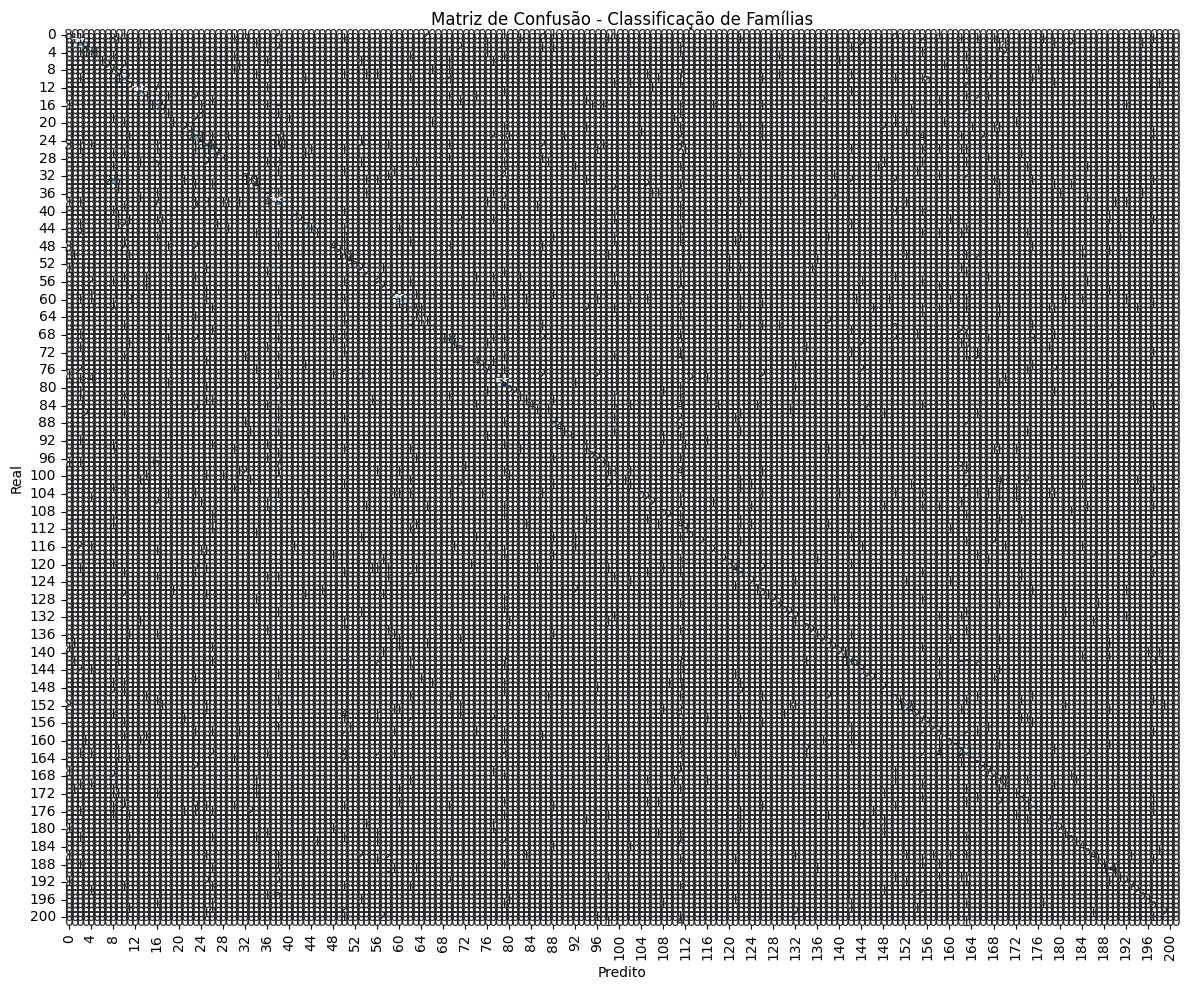


📈 RELATÓRIO DE CLASSIFICAÇÃO (Resumido):
                   precision    recall  f1-score   support

     Accipitridae      0.308     0.333     0.320        24
    Acipenseridae      0.200     0.056     0.087        18
      Acroporidae      0.517     0.738     0.608        42
         Agamidae      0.500     0.250     0.333        12
      Agariciidae      0.545     0.750     0.632        24
        Albulidae      0.000     0.000     0.000         6
      Alcedinidae      1.000     0.167     0.286         6
    Alligatoridae      1.000     0.333     0.500         6
        Alopiidae      0.099     0.583     0.169        12
   Ambystomatidae      0.182     0.167     0.174        12
         Anatidae      0.362     0.472     0.410        36
         Anguidae      0.294     0.417     0.345        12
          Aotidae      0.000     0.000     0.000        12
           Apidae      0.824     0.933     0.875        30
         Ardeidae      0.375     0.250     0.300        12
   Arthrolept

In [ ]:
# =============================================================================
# BLOCO 3: ANÁLISE DE MÉTRICAS DE PERFORMANCE (SEMANA 3) - CORRIGIDO
# =============================================================================
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

def comprehensive_metrics_analysis(model, train_data, label_encoder):
    """Análise completa de métricas de performance - CORRIGIDA"""

    print(" ANÁLISE DETALHADA DE MÉTRICAS")
    print("=" * 50)

    # Preparar dados de validação
    data_list = []
    for i in range(len(train_data)):
        item = train_data[i]
        data_list.append({
            'original_index': i,
            'family': item['family'],
            'species': item['species'],
            'target': item['family']
        })

    # Usar 20% para validação final
    train_list, val_list = train_test_split(
        data_list, test_size=0.2, random_state=42,
        stratify=[item['target'] for item in data_list]
    )

    # Criar dataset de validação
    _, val_transform = get_transforms(128)
    val_dataset = OptimizedDataset(val_list, 'family', val_transform)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()

    # Fazer previsões
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Métricas gerais
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='weighted', zero_division=0
    )

    print(f"MÉTRICAS GERAIS:")
    print(f"   Acurácia: {accuracy:.3f} ({accuracy*100:.2f}%)")
    print(f"   Precisão: {precision:.3f}")
    print(f"   Recall: {recall:.3f}")
    print(f"   F1-Score: {f1:.3f}")

    # Matriz de confusão
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(all_labels, all_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Matriz de Confusão - Classificação de Famílias')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

    # CORREÇÃO: Relatório de classificação para todas as classes
    class_names = label_encoder.classes_

    print(f"\n📈 RELATÓRIO DE CLASSIFICAÇÃO (Resumido):")
    # Mostrar apenas métricas gerais para não poluir
    print(classification_report(
        all_labels, all_predictions,
        target_names=class_names,
        zero_division=0,
        digits=3
    ))

    # Análise por classe - Top 10 melhores e piores
    print(f"\n TOP 10 CLASSES COM MELHOR PERFORMANCE:")
    accuracy_by_class = {}
    for class_idx in range(len(class_names)):
        mask = np.array(all_labels) == class_idx
        if mask.sum() > 0:
            accuracy_by_class[class_idx] = {
                'accuracy': (np.array(all_predictions)[mask] == class_idx).mean(),
                'support': mask.sum()
            }

    # Melhores classes
    sorted_best = sorted(accuracy_by_class.items(), key=lambda x: x[1]['accuracy'], reverse=True)
    for i, (class_idx, metrics) in enumerate(sorted_best[:10]):
        class_name = class_names[class_idx]
        acc = metrics['accuracy']
        support = metrics['support']
        print(f"   {i+1:2d}. {class_name:25} {acc:.3f} ({acc*100:.1f}%) - {support} exemplos")

    # Piores classes (com pelo menos 5 exemplos)
    print(f"\n  CLASSES COM BAIXA PERFORMANCE (≥5 exemplos):")
    problematic = [(class_idx, metrics) for class_idx, metrics in accuracy_by_class.items()
                  if metrics['accuracy'] < 0.5 and metrics['support'] >= 5]
    problematic.sort(key=lambda x: x[1]['accuracy'])

    for i, (class_idx, metrics) in enumerate(problematic[:10]):
        class_name = class_names[class_idx]
        acc = metrics['accuracy']
        support = metrics['support']
        print(f"   {i+1:2d}. {class_name:25} {acc:.3f} ({acc*100:.1f}%) - {support} exemplos")

# Executar análise de métricas
print("\n" + "="*60)
print("ANÁLISE DE MÉTRICAS - SEMANA 3")
print("="*60)

# Usar o modelo treinado anteriormente
comprehensive_metrics_analysis(model, train_data, label_encoder)